# Gena Enformer Usage
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIRI-Institute/GENA_LM/blob/main/notebooks/gena_enformer_usage.ipynb)

In this notebook we will finde mutations that are linked with TXNL4A gene with the help of GENA model that was trained on dataset from Enformer article.

# Install/Import libs


In [1]:
! pip install transformers
! pip install pysam
! pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.7 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import pysam # indexation starts from 1!
from Bio.Seq import Seq

In [3]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Download data

Firstly, we need to download full human genome assembly

In [4]:
! wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz

--2023-08-29 23:35:56--  https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948731419 (905M) [application/x-gzip]
Saving to: ‘hg19.fa.gz’

hg19.fa.gz          100%[===================>] 904.78M  40.8MB/s    in 23s     

2023-08-29 23:36:20 (39.0 MB/s) - ‘hg19.fa.gz’ saved [948731419/948731419]



In [5]:
! gunzip hg19.fa.gz

# Device check

Checking available hardware

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Download model

Now let's download one model of the GENA model family from Huggingface that was finetuned on Enformer dataset. [Link](https://huggingface.co/AIRI-Institute) to all models.

In [8]:
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t')
model = AutoModel.from_pretrained('AIRI-Institute/gena-lm-bert-base-t2t', trust_remote_code=True, revision='enformer').to('cpu')

In [9]:
model.eval()

BertForEnformer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (pre_attention_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (post_attention_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (softmax): Sof

# Main part

Reading and indexing .fa file of human genome

In [10]:
hg19 = pysam.FastaFile('hg19.fa')

# Get sequence from hg19 without mutations

Define needed constants

In [11]:
sp = torch.nn.Softplus() # define activation function of the last layer
position_to_look_at = 77_748_532 # set the center of all sequences (TXNL4A)
margin = 1430 # +- bp from the center of the sequence

In [12]:
# select sequence without mutations (and make sure it is in uppercase)
seq_good = hg19.fetch('chr18', position_to_look_at - 1 - margin, position_to_look_at + margin).upper()

In [13]:
# just selected sequence
seq_good

'CGCATCAGAATTCCCTGAGGGGCTTCTTTAAAAAGCCATTGCTGGACTTCACCCCATACCCATAGAATCAGAATCACAGATGCATTCTAGTAAGCACTCCAAGGGAGTCTTGTAATAACTAAAATATAACAACAGTTCCTAACTTCATGCCTCTCCTACTAAATAAGAAATAGCAAAAATTAATAAATGGCAGGCCAGATAGTCTTTCCTTTCCTGAATATAAAATATGTCCTTACATCTGTTACTCTTTACTCAAAGGAGTTATTTTAACCCAGGCCTACTTTTTAGCATCTGTGAAAGAAAAGATAGCTTCAATGTTACTTTTACTCTTCATTAAAAGGAATAACCTCTCAAATTACTTATGGAAAATTAATATGGCAAATATTTTATTAACACCCTAGTATTTGTGCCCTTTGCCCTATTGCTACAGCTGCAAAACCTCAATAAAAGTCATCCTAAAATTGCTATGAGGAACCACAGAAAAAGAATGAAATCTGGTTATAAAATAGTGTCCTACAACTTTTATTGTCAGCAAGTAAATGCCAAGACCACTCAGTGTACTAATATTAGAAATTCAGAGAACTAATTCTAACAAAGCATATTTCTATTTTCTCCTGATGTTTACTGCACCTCAATCACTGTAAGCTGTAAACCACATGACTCACAAAAAGCGTGGTGGGATAAAAAAACACACCCACAGAAAAGCAGGATTTCTCATGCTATGAACATGAAAGTCCTGCTTTATGCATACAACGAATAACTCAGGTACCAAAAAAAGACGTCCTTTTAAATTAAGGATCCGCGCTCTCAATAAAACCTGCAAGTGCATTTTGTTCACTGAACTATAAGTTTGGGAAAAACGCCTTATCAACAGAAATAATTAATTCATTTGAGAGGAGGGGGATCATAAACCCTTTAAAATATGAAAAACTACAAGAGCTCCCCGCAGAAAAAGGCGTGAAACGCCGGCACAGTCCCCGAGAGCGCTCGACCGCAGCG

In [14]:
# check its length
len(seq_good)

2861

Make selected sequence to be reverse complemented

In [15]:
seq_good = Seq(seq_good)
seq_good = str(seq_good.reverse_complement())

In [16]:
# look at the reverse complemented sequence
seq_good

'GTGAAGTGGTGCGATCTCAGCTCACTGCAACCTCCACCCCCTGGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCTAGTAGCTGGGATTATAGGCGGGCGCCACCATGCCCGGGTAATTTTTTGTATTTTTAGTAGAGACGGGGTTTCACCATGTTGGCCAGACTGGTCTTGAACTCCCGACCATAGGCGATCCGCCGGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCGCGCCCGGGCGTGATTTGTTTTAAATTTGTCATCTAAAGGACCACCAGGATAGCTAGATAGTAGACAAGAGTTTTACTATCAATATCAGTTTGCAAACCAGGGAGTCTCCAGCATGAACCCAAAGTGCTCTCTCAGAAGAACAGAGGTTAGAGGTTTTATTTTAAAAAGAGAAATATTAACTTATTTCTCTTTGAGAAAGTTCACTGGCACTAGTAAGGGTTTGGGGAGCTCTGACTGGTGAGCGAAGCCAGGGGGCCAGATCAGTCCTGGAGGTGGAAGTTATGCTGAAGCTATGGAATAAAACTGGCTTTAGGTCGGGCGCGGTGGCTTCTTCCTGTAATTTCAGCGCTTTGGGAGGCCGAGGCGGGCAGATCACTTGAGGTCAGGAGTTCAAGACCAGCCTGGCCAACATGGTTAAACCCCGTCTCTACTAAGTACAAAAAAACACTAGCCGGGCTGGCGCCTTGTAGTCCCAGCTTATGGGGAGGCGGAGGCAGGAGAAGCGCTTGACCCCGGGAGGCGGAGGCTGCAGTGGGCCAAGATCACGTCACTGCACGTCTCAAAAAAAAATTTTTTTTCTTTATAAAAAGACAAATTAAAAAACCTGGTTTCAGGTTACAACAGGCAGCTCAGCAGCCGGCCTGATGGTGACATTCCTCAAGGACGGCCTGCCCAGTGCTTCCTCCCTACCCCGCTGCTCGACTCTGCTGTGGTTGGGTATGGCAACAACGACACATTTTTATGATCAAGTTTCACAA

Tokenize selected sequence and split it in bins

In [17]:
counter = 0
all_token_ids_good = [tokenizer.cls_token_id] # make sure the fires token is CLC token
while 1:
    the_bin = seq_good[counter:counter+128] # of bins have the length of 128 bp
    if len(the_bin) == 0:
        break
    else:
        all_token_ids_good += tokenizer(the_bin, add_special_tokens=False, return_attention_mask=False, return_token_type_ids=False)['input_ids'] + [tokenizer.sep_token_id] # make sure to set SEP token after every bin
        counter += 128

In [18]:
# here is the tokenized sequence
torch.tensor(all_token_ids_good)

tensor([    1,   193,   652,   317, 12086, 24159,    48, 20992,  3112,    93,
         4235,  3535,  3504,    89,  2515,    15,     2,   119,  5576,  3729,
         1578,  5402,   561,    32, 16807,  9994,   185,  7679,  6165,   200,
          193,    26,     2,   282,   121,   105,   674, 31155, 12515,    44,
         3021,   269,   306,  1210,   534,  1257,   214,    51,  2024,   712,
          235,   441, 17867,   486,    21,     2,    34,  5315,   893,   181,
          321,  6840,  7457,  4385,   222,   945,   359,  1069,  1219,  1743,
          286,  3465,   169,  6477,   233, 12432,     6,     2,    25,   436,
          734,   404,   224,  3003,    75,   605,  2640,  7379,  1002, 12266,
        25312, 13755, 12121,   403, 15542,     2,   101,  1558,    81, 16942,
         5496,   721,   364,   256,   200, 10847,   730,  1431,   187,  3532,
         2092,   294,  4967,   152,  3532,    58,     2,    40,  5307,   966,
          120,   427, 11101,   131,   331,  8490,  4177,  3862, 

In [19]:
len(all_token_ids_good) # here is the amount of tokens we've got

499

Make tokens to be suitable to GENA's input shape. 'input_ids', 'token_type_ids' and 'attention_mask' are default parameters for Transformer models from Huggingface. The only difference is that we pass 'bins_mask' to get output only from SEP tokens that are the ends of bins.

In [20]:
all_token_ids_good = np.array(all_token_ids_good)
token_type_ids = np.array([0] * len(all_token_ids_good))
attention_mask = np.array([1] * len(all_token_ids_good))
bins_mask = (all_token_ids_good == tokenizer.sep_token_id).astype(bool)

tokenized_seq_good = {'input_ids': all_token_ids_good,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask,
                'bins_mask': bins_mask}

tokenized_seq_good['input_ids'] = torch.tensor([tokenized_seq_good['input_ids']]).to(device)
tokenized_seq_good['token_type_ids'] = torch.tensor([tokenized_seq_good['token_type_ids']]).to(device)
tokenized_seq_good['attention_mask'] = torch.tensor([tokenized_seq_good['attention_mask']]).to(device)
tokenized_seq_good['bins_mask'] = torch.tensor([tokenized_seq_good['bins_mask']]).to(device)

<ipython-input-20-860ac5930e12>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  tokenized_seq_good['input_ids'] = torch.tensor([tokenized_seq_good['input_ids']]).to(device)
<ipython-input-20-860ac5930e12>:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  tokenized_seq_good['bins_mask'] = torch.tensor([tokenized_seq_good['bins_mask']]).to(device)


In [21]:
# here is the full input that is passed into the model
tokenized_seq_good

{'input_ids': tensor([[    1,   193,   652,   317, 12086, 24159,    48, 20992,  3112,    93,
           4235,  3535,  3504,    89,  2515,    15,     2,   119,  5576,  3729,
           1578,  5402,   561,    32, 16807,  9994,   185,  7679,  6165,   200,
            193,    26,     2,   282,   121,   105,   674, 31155, 12515,    44,
           3021,   269,   306,  1210,   534,  1257,   214,    51,  2024,   712,
            235,   441, 17867,   486,    21,     2,    34,  5315,   893,   181,
            321,  6840,  7457,  4385,   222,   945,   359,  1069,  1219,  1743,
            286,  3465,   169,  6477,   233, 12432,     6,     2,    25,   436,
            734,   404,   224,  3003,    75,   605,  2640,  7379,  1002, 12266,
          25312, 13755, 12121,   403, 15542,     2,   101,  1558,    81, 16942,
           5496,   721,   364,   256,   200, 10847,   730,  1431,   187,  3532,
           2092,   294,  4967,   152,  3532,    58,     2,    40,  5307,   966,
            120,   427, 111

# Get sequences with mutations

Loading substitutions

In [190]:
substitutions = pd.read_csv('HSE.task3.table_sample.csv')
substitutions

,Unnamed: 0,pos,ref,alt
0,1,77748624,T,C
1,2,77747596,C,-


Here we select needed region and make it reverse complementary for every substitution

In [191]:
expander = 4 # +- bp from substitution for preview
mut_seqs = [] # array of rev compl sequences

for i in range(num_rows := substitutions.shape[0]):
    start = substitutions.iloc[i, 1]
    if abs(position_to_look_at - start) > margin:
        print('Location of substitution is out of range (+- margin)!')
        break
    print(f'Done {i}/{num_rows-1}')
    sub = substitutions.iloc[i, 3]
    gt = substitutions.iloc[i, 2]
    tmp_start = start - 1 - expander
    tmp_end = start - 1 + expander + len(gt)
    if sub == '-':
        current_seq = hg19.fetch('chr18', position_to_look_at - 1 - margin, start - 1).upper() + \
         hg19.fetch('chr18', start - 1 + len(gt), position_to_look_at + margin).upper() # upper because tokenizer was pretrained on uppercase DNA
    else:
        current_seq = hg19.fetch('chr18', position_to_look_at - 1 - margin, start - 1).upper() + sub + \
         hg19.fetch('chr18', start, position_to_look_at + margin).upper()
    print(f'Total length of sequence: {len(current_seq)}')
    current_seq_rc = str(Seq(current_seq).reverse_complement())
    if sub == '-':
        print(f"Close look of the substitution: {tmp_start} --> {hg19.fetch('chr18', tmp_start, tmp_end).upper()} <-- {tmp_end}, substitution {gt} -> {sub} from position {start - 1}, get {current_seq[margin - (position_to_look_at - start) - expander: margin - (position_to_look_at - start) + expander]}, rev compl subseq: {current_seq_rc[::-1][margin - (position_to_look_at - start) - expander: margin - (position_to_look_at - start) + expander][::-1]}")
    else:
        print(f"Close look of the substitution: {tmp_start} --> {hg19.fetch('chr18', tmp_start, tmp_end).upper()} <-- {tmp_end}, substitution {gt} -> {sub} from position {start - 1}, get {current_seq[margin - (position_to_look_at - start) - expander: margin - (position_to_look_at - start) + expander + 1]}, rev compl subseq: {current_seq_rc[::-1][margin - (position_to_look_at - start) - expander: margin - (position_to_look_at - start) + expander + 1][::-1]}")
    mut_seqs.append(current_seq_rc)

Done 0/1
Total length of sequence: 2861
Close look of the substitution: 77748619 --> TGCGTGCTG <-- 77748628, substitution T -> C from position 77748623, get TGCGCGCTG, rev compl subseq: CAGCGCGCA
Done 1/1
Total length of sequence: 2860
Close look of the substitution: 77747591 --> AAATCTGGT <-- 77747600, substitution C -> - from position 77747595, get AAATTGGT, rev compl subseq: ACCAATTT


# Tokenize sequences with mutations

In [192]:
mut_seqs_tokenized = [] # array of all tokenized sequences of substitutions
for i in range(arr_len := len(mut_seqs)):
    seq = mut_seqs[i]
    counter = 0
    all_token_ids_mut = [tokenizer.cls_token_id]
    while 1:
        the_bin = seq[counter:counter+128]
        if len(the_bin) == 0:
            break
        else:
            all_token_ids_mut += tokenizer(the_bin, add_special_tokens=False,
                                           return_attention_mask=False,
                                           return_token_type_ids=False)['input_ids'] + [tokenizer.sep_token_id]
            counter += 128

    all_token_ids_mut = np.array(all_token_ids_mut)
    token_type_ids = np.array([0] * len(all_token_ids_mut))
    attention_mask = np.array([1] * len(all_token_ids_mut))
    bins_mask = (all_token_ids_mut == tokenizer.sep_token_id).astype(bool)

    tokenized_seq_mut = {'input_ids': all_token_ids_mut,
                    'token_type_ids': token_type_ids,
                    'attention_mask': attention_mask,
                    'bins_mask': bins_mask}

    tokenized_seq_mut['input_ids'] = torch.tensor([tokenized_seq_mut['input_ids']]).to(device)
    tokenized_seq_mut['token_type_ids'] = torch.tensor([tokenized_seq_mut['token_type_ids']]).to(device)
    tokenized_seq_mut['attention_mask'] = torch.tensor([tokenized_seq_mut['attention_mask']]).to(device)
    tokenized_seq_mut['bins_mask'] = torch.tensor([tokenized_seq_mut['bins_mask']]).to(device)

    if len(tokenized_seq_mut['input_ids']) > 512:
        print(f'Too big sequence to fit in the model!')
        break

    mut_seqs_tokenized.append(tokenized_seq_mut)
    print(f"Done {i}/{arr_len-1}, num tokens: {len(tokenized_seq_mut['input_ids'][0])}")

Done 0/1, num tokens: 499
Done 1/1, num tokens: 496


<ipython-input-192-1129edeeb749>:29: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  tokenized_seq_mut['bins_mask'] = torch.tensor([tokenized_seq_mut['bins_mask']]).to(device)


# Make predictions

For sequence with no mutations

In [193]:
good_seq_preds = model(**tokenized_seq_good).logits.detach().cpu().numpy().squeeze()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [194]:
good_seq_preds.shape

(23, 5313)

Fot sequences with mutations

In [195]:
mut_seq_preds = []
for i in range(arr_len := len(mut_seqs)):
    mut_seq_preds.append(cp := model(**mut_seqs_tokenized[i]).logits.detach().cpu().numpy().squeeze())
    print(f'Shape of the prediction: {cp.shape}, num bins: {cp.shape[0]}')
    print(f'Done {i}/{arr_len-1}')

Shape of the prediction: (23, 5313), num bins: 23
Done 0/1
Shape of the prediction: (23, 5313), num bins: 23
Done 1/1


# Plot results

In [196]:
selected_cell_type = 4790

<Figure size 640x480 with 0 Axes>

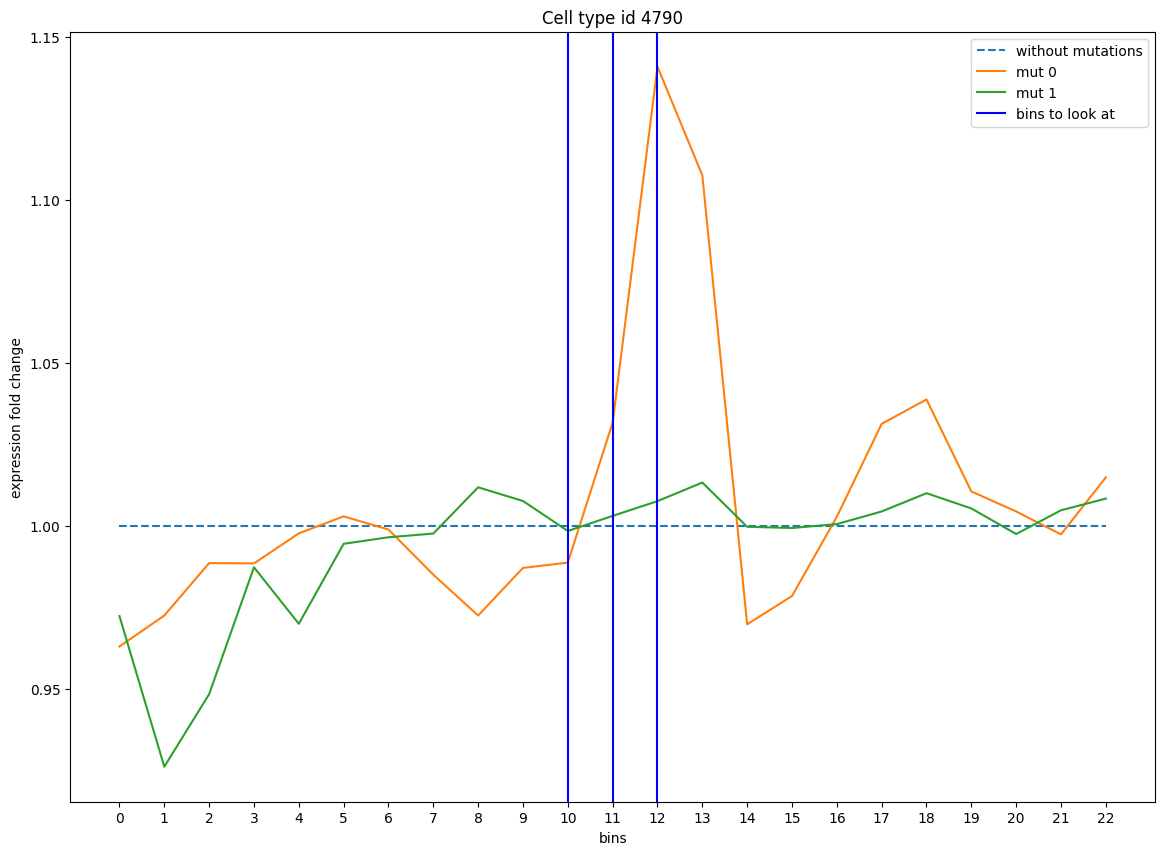

In [197]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
normalizer = sp(torch.tensor(good_seq_preds[:, 1])).numpy()[::-1]
ax.plot(np.ones(len(normalizer)), label='without mutations', linestyle='dashed')
for i in range(len(mut_seq_preds)):
    ax.plot((e := sp(torch.tensor(mut_seq_preds[i][:, 1])).numpy()[::-1]) / normalizer[:len(e)], label=f'mut {i}')
ax.set_title('Cell type id 4790')
ax.set_xlabel('bins')
ax.set_ylabel('expression fold change')
ax.axvline(x = margin // 128 - 1, color = 'b', label = 'bins to look at')
ax.axvline(x = margin // 128, color = 'b')
ax.axvline(x = margin // 128 + 1, color = 'b')
ax.set_xticks(xt := np.arange(len(e)))
ax.set_xticklabels(list(map(lambda t: str(t), list(xt))))
ax.legend(fontsize=10)
plt.show()